In [84]:
# import
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [85]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [86]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [87]:
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [88]:
def get_market_exit_signal(index_data, long_term_ma):
    index_data['Long_Term_MA'] = index_data['Close'].rolling(window=long_term_ma).mean()
    if index_data['Close'].iloc[-1] < index_data['Long_Term_MA'].iloc[-1]:
        return "Exit Market"
    return "Stay"
def check_buy_signal(stock_data, short_window=5, long_window=20, rsi_buy_signal=40, rsi_window = 14):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for buy signal
    buy_signal = (stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1]) and \
                 (stock_data['RSI'].iloc[-1] < rsi_buy_signal) and \
                 (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return buy_signal, stock_data

def check_sell_signal(stock_data, short_window=5, long_window=20, rsi_sell_signal=90, rsi_window = 14):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for sell signal
    sell_signal = (stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]) and \
                  (stock_data['RSI'].iloc[-1] > rsi_sell_signal) and \
                  (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return sell_signal, stock_data

In [89]:
def decide_trade(stock_data, short_window, long_window, rsi_buy_signal=40, rsi_sell_signal=90, rsi_window=14):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    buy_signals = (stock_data['Short_MA'] < stock_data['Long_MA']) & (stock_data['RSI'] < rsi_buy_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    sell_signals = (stock_data['Short_MA'] > stock_data['Long_MA']) & (stock_data['RSI'] > rsi_sell_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    
    return buy_signals, sell_signals

In [90]:
def recommended_pe_ratio(sector):
    pe_ratios = {
        'Technology': (25, 35),
        'Utilities': (10, 20),
        'Consumer Discretionary': (15, 25),
        'Healthcare': (15, 25),
        'Pharmaceuticals': (15, 25),
        'Financial': (10, 15),
        'Energy': (5, 15),
        'Industrials': (15, 25),
        'Materials': (15, 25),
        'Real Estate': (15, 25),
        'Telecommunication': (10, 15),
        'Consumer Staples': (20, 25),
        'Information Technology': (25, 35)
    }
    
    return pe_ratios.get(sector, ('N/A', 'N/A'))  # Default to 'N/A' if the sector is not listed

# Example usage
sector = 'Technology'
print(f"Recommended P/E Ratio for {sector}: {recommended_pe_ratio(sector)}")

Recommended P/E Ratio for Technology: (25, 35)


In [91]:
def backtest_strategy(stock_data, buy_signals, sell_signals, holding_period=30, investment_fraction=0.1):
    initial_balance = 10000  # Example starting balance
    balance = initial_balance
    position = 0
    purchase_price = 0  # To track the purchase price of the stock
    holding_start_date = None  # To track when a stock is bought
    trade_history = []

    for i in range(len(stock_data)):
        current_date = stock_data.index[i]
        current_price = stock_data['Close'][i]

        if buy_signals[i] and balance >= current_price:
            # Buy - use only a fraction of the available balance
            investment_amount = balance * investment_fraction
            shares_to_buy = investment_amount // current_price
            if shares_to_buy > 0:  # Ensuring we have enough balance to buy at least one share
                balance -= shares_to_buy * current_price
                position += shares_to_buy
                purchase_price = current_price
                holding_start_date = current_date
                trade_history.append(('BUY', current_date, current_price, shares_to_buy))

        elif sell_signals[i] and position > 0:
            days_held = (current_date - holding_start_date).days if holding_start_date else 0
            is_profit = current_price > purchase_price

            # Sell if held for at least 30 days or at a loss
            if days_held >= holding_period or not is_profit:
                balance += position * current_price
                trade_history.append(('SELL', current_date, current_price, position))
                position = 0
                holding_start_date = None
                purchase_price = 0

    final_balance = balance + (position * stock_data['Close'].iloc[-1])
    total_return = final_balance - initial_balance
    return_percentage = (total_return / initial_balance) * 100

    return trade_history, total_return, return_percentage

[*********************100%%**********************]  1 of 1 completed

Analyzing NVDA...
Buy signals for NVDA:
                  Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2023-09-21  41.583000  42.099998  40.980000  41.016998  41.008102  450736000   
2023-09-22  41.571999  42.115002  41.230999  41.610001  41.600971  479236000   
2023-09-27  42.330002  42.872002  41.629002  42.467999  42.458786  444935000   
2023-10-02  44.029999  45.174999  43.861000  44.782001  44.772285  433298000   
2023-10-03  44.807999  45.130001  43.245998  43.516998  43.507557  470850000   
2023-10-06  44.193001  45.789001  44.026001  45.762001  45.752071  434436000   
2023-10-26  41.853001  42.256001  39.880001  40.326000  40.317253  541001000   
2023-10-31  40.450001  40.879002  39.230000  40.779999  40.771152  517969000   
2023-11-09  47.466999  48.230000  46.750000  46.950001  46.939816  540496000   
2024-05-01  85.077003  86.000000  81.254997  83.041000  83.034180  559863000   

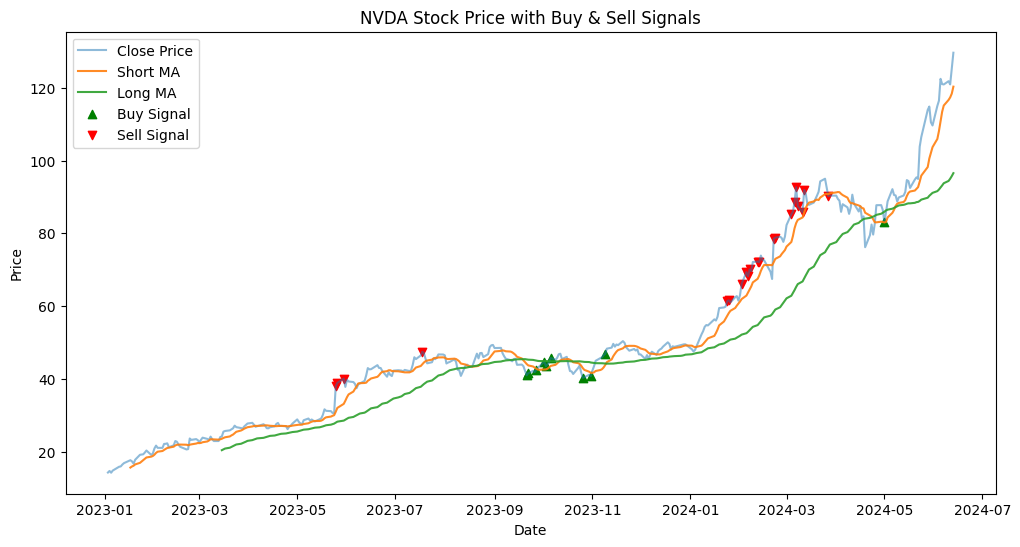

[*********************100%%**********************]  1 of 1 completed

Analyzing ADBE...
Buy signals for ADBE:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-12  340.510010  340.790009  331.890015  335.450012  335.450012   
2023-05-17  345.359985  358.690002  345.119995  356.630005  356.630005   
2023-05-19  363.000000  372.079987  361.359985  371.250000  371.250000   
2023-09-29  505.440002  518.580017  505.440002  509.899994  509.899994   
2023-10-06  513.219971  531.309998  509.519989  526.679993  526.679993   
2023-10-11  538.590027  551.340027  536.109985  549.909973  549.909973   
2023-10-12  553.700012  574.400024  552.229980  559.630005  559.630005   
2023-11-01  535.000000  545.270020  534.000000  544.500000  544.500000   
2023-11-02  550.440002  559.359985  550.000000  558.710022  558.710022   
2023-11-06  566.000000  567.880005  558.169983  565.450012  565.450012   
2024-01-08  567.869995  581.510010  567.869995  580.549988  580.549988 

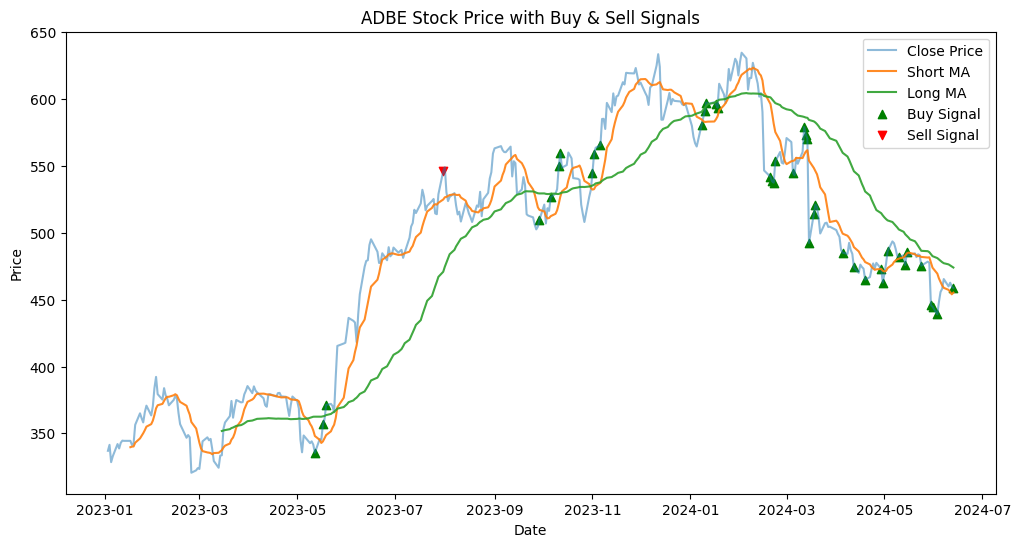

[*********************100%%**********************]  1 of 1 completed

Analyzing AAPL...
Buy signals for AAPL:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-17  177.139999  177.509995  173.479996  174.000000  173.549622   
2023-08-18  172.300003  175.100006  171.960007  174.490005  174.038361   
2023-08-23  178.520004  181.550003  178.330002  181.119995  180.651184   
2023-08-24  180.669998  181.100006  176.009995  176.380005  175.923462   
2023-08-25  177.380005  179.149994  175.820007  178.610001  178.147690   
2023-08-29  179.699997  184.899994  179.500000  184.119995  183.643402   
2023-08-30  184.940002  187.850006  184.740005  187.649994  187.164276   
2023-08-31  187.839996  189.119995  187.479996  187.869995  187.383698   
2023-09-06  188.399994  188.850006  181.470001  182.910004  182.436539   
2023-09-07  175.179993  178.210007  173.539993  177.559998  177.100388   
2023-09-08  178.350006  180.240005  177.789993  178.179993  177.718781 

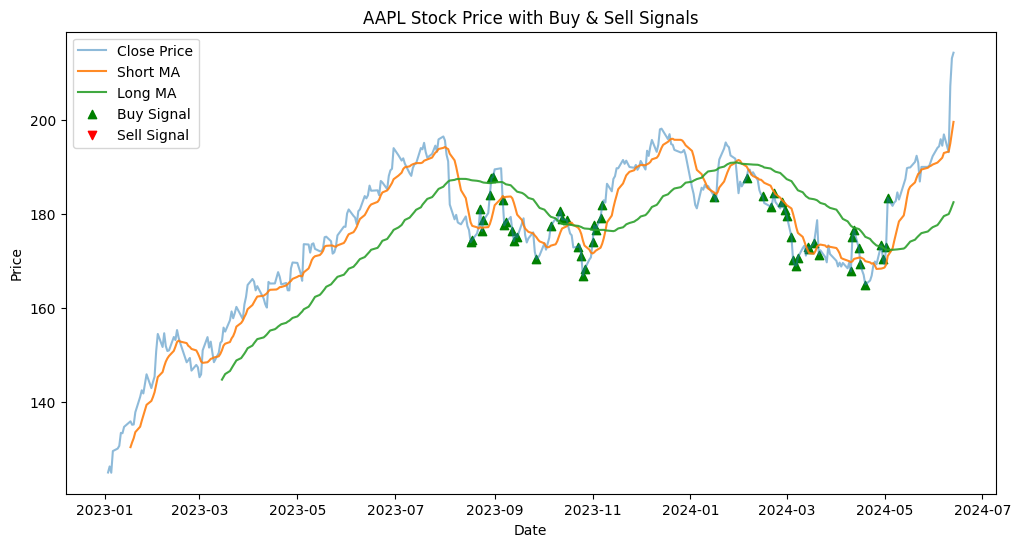

Analyzing META...


[*********************100%%**********************]  1 of 1 completed


Buy signals for META:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-25  286.130005  288.390015  276.029999  285.500000  285.197388   
2023-08-29  288.579987  299.149994  288.179993  297.989990  297.674164   
2023-09-07  298.000000  307.049988  292.220001  298.670013  298.353455   
2023-09-11  301.410004  309.040009  301.279999  307.559998  307.234009   
2023-09-14  306.739990  312.869995  305.029999  311.720001  311.389618   
2023-09-15  311.609985  312.000000  298.750000  300.309998  299.991699   
2023-09-27  300.450012  301.299988  286.790009  297.739990  297.424408   
2023-09-28  298.940002  306.329987  296.700012  303.959991  303.637817   
2023-09-29  307.380005  310.640015  299.359985  300.209991  299.891815   
2024-04-25  421.399994  445.769989  414.500000  441.380005  441.380005   
2024-04-26  441.459991  446.440002  431.959991  443.290009  443.290009   
2024-05-13  472

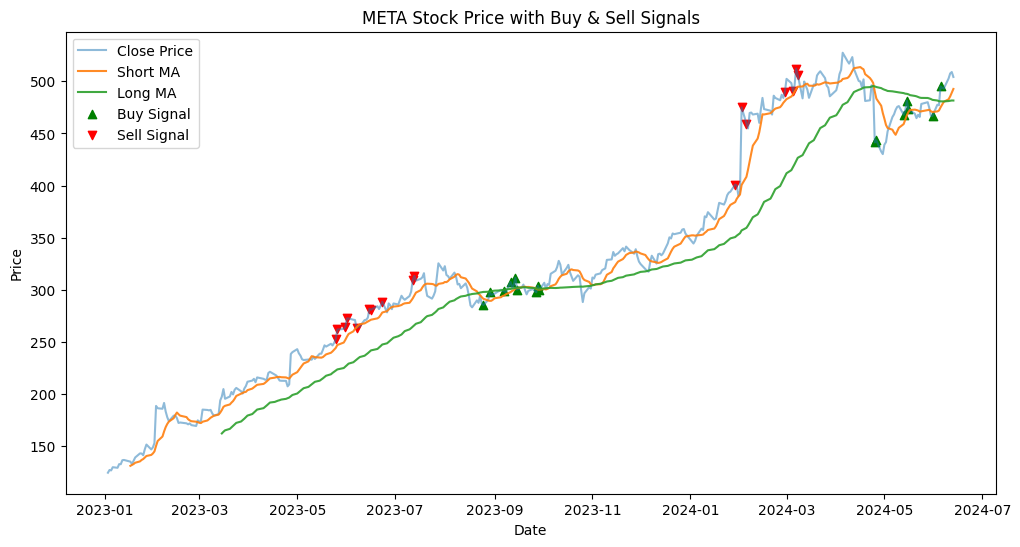

Analyzing SMCI...


[*********************100%%**********************]  1 of 1 completed

Buy signals for SMCI:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-23  260.290009  284.570007  259.250000  277.609985  277.609985   
2023-08-24  298.040009  298.350006  256.500000  262.500000  262.500000   
2023-08-25  261.000000  263.940002  243.009995  253.960007  253.960007   
2023-08-29  253.639999  277.600006  251.009995  261.630005  261.630005   
2023-08-30  263.739990  275.880005  257.320007  267.920013  267.920013   
2023-08-31  270.000000  283.040009  264.049988  275.079987  275.079987   
2023-09-15  268.000000  269.279999  247.199997  249.259995  249.259995   
2023-09-25  234.000000  250.059998  233.360001  248.860001  248.860001   
2023-09-27  252.919998  261.619995  251.080002  257.540009  257.540009   
2023-09-28  256.390015  272.589996  255.000000  269.380005  269.380005   
2023-09-29  274.010010  283.630005  273.000000  274.220001  274.220001   
2023-10-02  275

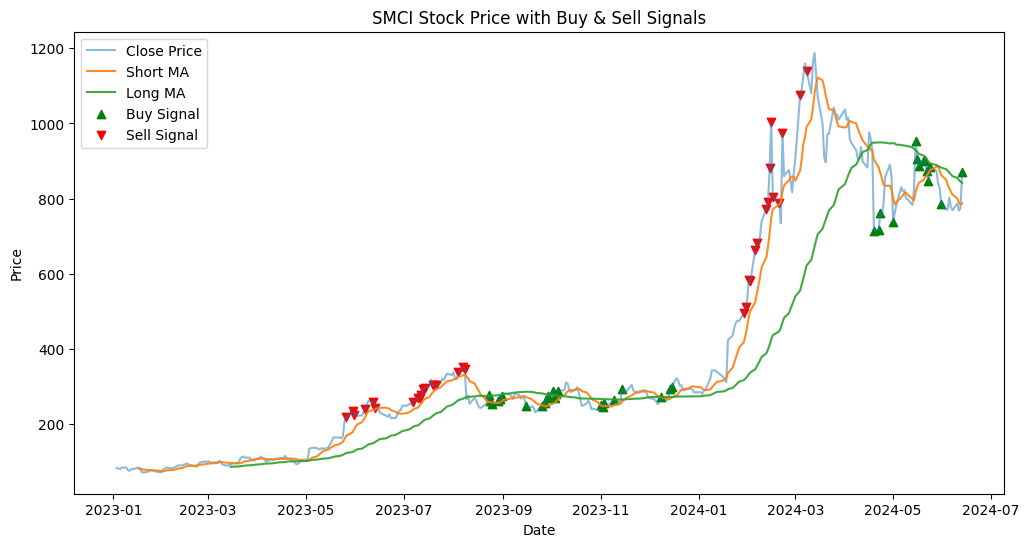

Analyzing BTC-USD...


[*********************100%%**********************]  1 of 1 completed


Buy signals for BTC-USD:
                     Open          High           Low         Close  \
Date                                                                 
2023-03-09  21720.080078  21802.716797  20210.306641  20363.021484   
2023-03-10  20367.001953  20370.595703  19628.253906  20187.244141   
2023-03-11  20187.876953  20792.525391  20068.660156  20632.410156   
2023-03-15  24770.925781  25240.615234  23964.910156  24375.960938   
2023-05-12  26987.662109  27055.646484  25878.429688  26804.990234   
2023-05-18  27401.650391  27466.527344  26415.101562  26832.208984   
2023-05-23  26855.960938  27434.683594  26816.179688  27225.726562   
2023-05-24  27224.603516  27224.603516  26106.576172  26334.818359   
2023-05-25  26329.460938  26591.519531  25890.593750  26476.207031   
2023-05-26  26474.181641  26916.669922  26343.949219  26719.291016   
2023-05-28  26871.158203  28193.449219  26802.751953  28085.646484   
2023-05-29  28075.591797  28432.039062  27563.876953  27745.8847

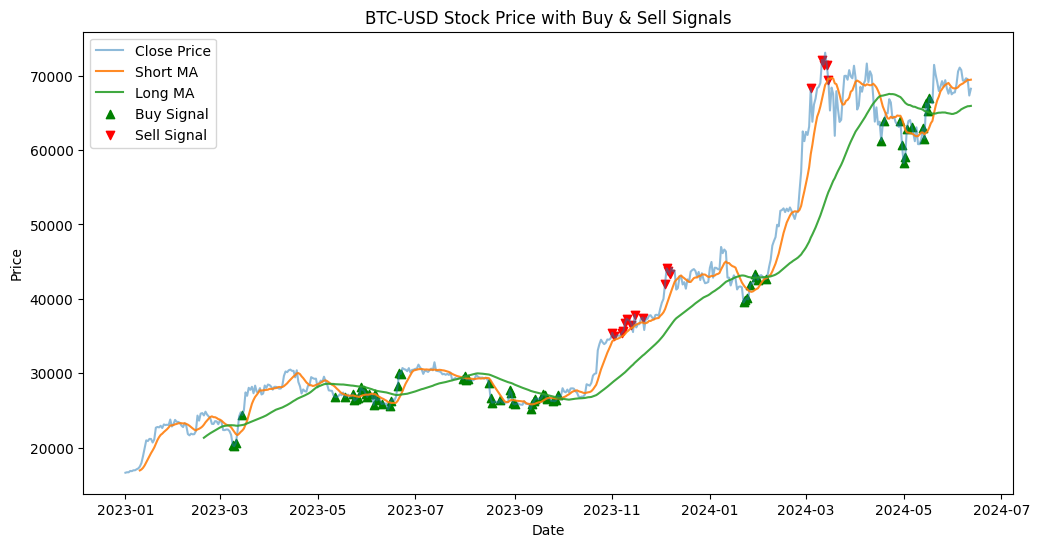

In [92]:

# # Define a list of stock tickers
tickers = ['NVDA','ADBE','AAPL','META','SMCI','BTC-USD']
# tickers = ['BABA','PDD','ARM','BTC-USD', 'ETH-USD','NVDA','SMCI','AMC','META','SAVE','LLY', 'BAC','SHOP']
# tickers = ['META', 'GOOG', 'AAPL', 'NVDA', 'BTC-USD','PDD','AMC']
start_date = '2023-01-01'
end_date = '2024-06-14'

# Monitor each stock
for ticker in tickers:
    print(f"Analyzing {ticker}...")
    stock = get_stock_data(ticker, start_date, end_date)
    buy, sell = decide_trade(stock, short_window=10, long_window=50, rsi_buy_signal=57, rsi_sell_signal=70, rsi_window=60)

    # You can store these results in a data structure or database
    print(f"Buy signals for {ticker}:\n", stock[buy])
    print(f"Sell signals for {ticker}:\n", stock[sell])

    # Optional: Plotting
    plt.figure(figsize=(12,6))
    plt.plot(stock['Close'], label='Close Price', alpha=0.5)
    plt.plot(stock['Short_MA'], label='Short MA', alpha=0.9)
    plt.plot(stock['Long_MA'], label='Long MA', alpha=0.9)
    plt.scatter(stock.index[buy], stock['Close'][buy], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(stock.index[sell], stock['Close'][sell], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{ticker} Stock Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

In [93]:

# # Example usage
# for ticker in tickers:
#   stock = get_stock_data(ticker, start_date, end_date)
#   buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal= 30, rsi_sell_signal=90)
#   trades, total_return, return_percentage = backtest_strategy(stock, buy, sell,30,0.1)
#   print(f"#######################{ticker}##########################")
#   print(f"Trades: {trades}")
#   print(f"Total Return: ${total_return:.2f}")
#   print(f"Return Percentage: {return_percentage:.2f}%")
#   print(f"Hold Return Percentage: {(stock['Close'][len(stock)-1]-stock['Close'][0])/stock['Close'][0]*100:.2f}%")


In [120]:
def get_stock_info_on_date(tickers, date=datetime.today().strftime("%Y-%m-%d"), history_days=600, long_term_ma=200, rsi_buy_signal=40, rsi_sell_signal=90, rs_window=14):
    print("Today is " + date)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=history_days)

    # market_index = yf.Ticker("^GSPC")  # S&P 500 Index
    # market_data = market_index.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    # market_signal = get_market_exit_signal(market_data, long_term_ma)
    # print(market_signal)

    data = {'Company Code': [], 'Date': [], 'Daily Price': [], 'Recommendation': [],'60 DAY RSI':[], 'P/E Ratio': [], 'Recommended PE':[], 'Category': [],'Dividend Yield': [], 'Market Cap': [], 'Earnings Growth': [], 'One Year Target': [], 'Analyst Buy': [], 'Analyst Hold': [], 'Analyst Sell': []}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if hist_data.empty:
            continue  # Skip if no data for the given date range
        
        last_date = hist_data.index[-1].strftime('%Y-%m-%d')  # Last date in the historical data
        daily_price = hist_data['Close'].iloc[-1]  # Last close price
        # Apply buy/sell signal functions (as previously defined)
        buy_signal, buy_data = check_buy_signal(hist_data, short_window=10, long_window=50, rsi_buy_signal=rsi_buy_signal, rsi_window=60)
        sell_signal, _ = check_sell_signal(hist_data, short_window=10, long_window=50, rsi_sell_signal=rsi_sell_signal, rsi_window=60)
        recommendation = 'BUY' if buy_signal else 'SELL' if sell_signal else None

        if recommendation:
            pe_ratio = stock.info.get('trailingPE', 'N/A')
            category = stock.info.get('sector', 'N/A')
            dividend_yield = stock.info.get('dividendYield', 'N/A') * 100 if stock.info.get('dividendYield') is not None else 'N/A'
            market_cap = stock.info.get('marketCap', 'N/A')
            earnings_growth = stock.info.get('earningsGrowth', 'N/A')
            one_year_target = stock.info.get('targetMeanPrice')
            analyst_buy_ratings = stock.info.get('buyRatingCount')
            analyst_hold_ratings = stock.info.get('holdRatingCount')
            analyst_sell_ratings = stock.info.get('sellRatingCount')
            data['Company Code'].append(ticker)
            data['Recommendation'].append(recommendation)
            data['60 DAY RSI'].append(buy_data['RSI'].iloc[-1])
            data['P/E Ratio'].append(pe_ratio)
            data['Category'].append(category)
            data['Dividend Yield'].append(dividend_yield)
            data['Market Cap'].append(market_cap)
            data['Earnings Growth'].append(earnings_growth)
            data['Recommended PE'].append(recommended_pe_ratio(category))
            data['One Year Target'].append(one_year_target)
            data['Analyst Buy'].append(analyst_buy_ratings)
            data['Analyst Hold'].append(analyst_hold_ratings)
            data['Analyst Sell'].append(analyst_sell_ratings)
            data['Date'].append(last_date)
            data['Daily Price'].append(daily_price)

    return pd.DataFrame(data)


In [95]:
def get_sp500_tickers():
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # sp500_table = pd.read_html(url, header=0)[0]
    # tickers = sp500_table['Symbol'].tolist()
    # print(tickers)
    # return tickers
    return ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WRB', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']

sp500_tickers = get_sp500_tickers()

In [96]:
def get_nasdaq_tickers():
    # url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    # tables = pd.read_html(url)  # Scrapes all tables from the Wikipedia page
    # nasdaq_table = tables[4]  # The table with NASDAQ tickers is typically the fourth table on the page
    # nasdaq_tickers = nasdaq_table['Ticker'].tolist()  # Extracts the tickers into a list
    # return nasdaq_tickers
    return ['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']

nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)

['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']


# Useless Stock Filter

In [97]:
# # Rules
# def rule_price_above_moving_averages(stock_data):
#     """Price and 50-day MA higher than both 150-day and 200-day MAs."""
#     ma50 = stock_data['Close'].rolling(window=50).mean()
#     ma150 = stock_data['Close'].rolling(window=150).mean()
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price)
#     # print(ma50.iloc[-1])
#     # print(ma150.iloc[-1])
#     # print(ma200.iloc[-1])
#     # print(current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1])
#     return current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1]

# def rule_ma200_uptrend(stock_data, days=30):
#     """200-day MA has been in an uptrend for at least 'days' days."""
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     # for every ten days, check if it is still the trend
#     for i in range(-1, -days, -10):
#         # print(ma200.iloc[-10*i-1],ma200.iloc[-10*i+9])
#         if ma200.iloc[-10*i-1] >= ma200.iloc[-10*i+9]:
#             return False
#     # print(ma200.iloc[-1] > ma200.iloc[-days])
#     return True 
#     # return ma200.iloc[-1] > ma200.iloc[-days]

# def rule_price_above_52week_low(stock_data, threshold=0.25):
#     """Current price is at least 'threshold' % higher than the 52-week low."""
#     low_52week = stock_data['Close'].rolling(window=252).min().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= low_52week * (1 + threshold))
#     return current_price >= low_52week * (1 + threshold)

# def rule_price_near_52week_high(stock_data, threshold=0.25):
#     """Current price is within 'threshold' % of the 52-week high."""
#     high_52week = stock_data['Close'].rolling(window=252).max().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= high_52week * (1 - threshold))
#     return current_price >= high_52week * (1 - threshold)

In [98]:
# def stock_filter(tickers, rules,date = datetime.today().strftime("%Y-%m-%d")):
#     filtered_stocks = []
#     for ticker in tickers:
#         end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
#         min_history_days = 3*365
#         start_date = end_date - timedelta(days=min_history_days)
#         try:
#             data = yf.download(ticker, start=start_date, end=date, progress=False)
#             if all(rule(data) for rule in rules):
#                 filtered_stocks.append(ticker)
#             # else:
#                 # print(ticker + ' is not recommended to trade')
#         except:
#             continue
#     return filtered_stocks

In [99]:
# filter_rules = [
#     rule_price_above_moving_averages,
#     rule_ma200_uptrend,
#     rule_price_above_52week_low,
#     rule_price_near_52week_high
# ]

# # List of tickers
# # tickers = ['AAPL','AMD','ARKK','ARM','BA', 'BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
# tickers = nasdaq_tickers
# tickers.append(sp500_tickers)
# # tickers=['AAPL',"NVDA","TSLA","MSFT","COIN"]
# # tickers = ['NVDA']
# # Apply the filter
# filtered_stocks = stock_filter(tickers, filter_rules)
# print("Stocks that meet the criteria:", filtered_stocks)

In [100]:
# def test_stock_filter_performance(tickers, rules, start_date, end_date):
#     passed_stocks = stock_filter(tickers, rules, start_date)
#     failed_stocks = set(tickers) - set(passed_stocks)

#     return calculate_average_return(passed_stocks, start_date, end_date), calculate_average_return(failed_stocks, start_date, end_date), passed_stocks, failed_stocks

# def calculate_average_return(stocks, start_date, end_date):
#     returns = []
#     annualized_returns = []
#     start = datetime.strptime(start_date, '%Y-%m-%d')
#     end = datetime.strptime(end_date, '%Y-%m-%d')
#     days_in_period = (end - start).days
#     for ticker in stocks:
#         try:
#             stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
#             if not stock_data.empty:
#                 initial_price = stock_data['Close'].iloc[0]
#                 final_price = stock_data['Close'].iloc[-1]
#                 stock_return = (final_price - initial_price) / initial_price
#                 annualized_return = (1 + stock_return) ** (365.0 / days_in_period) - 1
#                 returns.append(stock_return)
#                 annualized_returns.append(annualized_return)
#         except:
#             continue
#     if returns:
#         return sum(returns) / len(returns), sum(annualized_returns)/len(annualized_returns)
#     else:
#         # need a better solution
#         return 0, 0

# # Example usage
# tickers = sp500_tickers
# start_date = "2023-01-01"
# end_date = '2023-12-01'

# average_return_passed, average_return_failed, passed_stocks, failed_stocks = test_stock_filter_performance(tickers, filter_rules, start_date, end_date)
# print("Average yearly Return of Passed Stocks:", average_return_passed[1], "Number of Passed Stocks: ", len(passed_stocks))
# print(passed_stocks)
# print("Average yearly Return of Failed Stocks:", average_return_failed[1], "Number of Failed Stocks: ", len(failed_stocks))

In [101]:

# def closest_trading_date(data, date):
#     """Find the closest previous trading date in the data for a given date."""
#     if date in data.index:
#         return date
#     # Iterate backwards to find the closest previous date
#     while date not in data.index:
#         date -= pd.Timedelta(days=1)
#     return date

# def test_filter_performance_over_periods(tickers, rules, start_date, end_date):
  
#     # Generate dates at regular intervals between start and end
#     date_range = pd.date_range(start=start_date, end=end_date, freq='M')
#     filtered_stocks = stock_filter(tickers, rules, start_date)
#     unfiltered_stocks = set(tickers) - set(filtered_stocks)

#     # Lists to store results
#     filtered_returns = []
#     unfiltered_returns = []
#     differences = []
#     sp500_returns = []

#     sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
#     for date in date_range:
#         trading_date = closest_trading_date(sp500, date)

#         filtered_avg_return, _ = calculate_average_return(filtered_stocks, start_date, date.strftime('%Y-%m-%d'))
#         unfiltered_avg_return, _ = calculate_average_return(unfiltered_stocks, start_date, date.strftime('%Y-%m-%d'))

#         sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

#         filtered_returns.append(filtered_avg_return if filtered_avg_return is not None else 0)
#         unfiltered_returns.append(unfiltered_avg_return if unfiltered_avg_return is not None else 0)
#         differences.append((filtered_avg_return - unfiltered_avg_return) if filtered_avg_return is not None and unfiltered_avg_return is not None else 0)
#         sp500_returns.append(sp500_return)

#     return date_range, filtered_returns, unfiltered_returns, differences, sp500_returns


# start_date = '2022-05-01'
# end_date = '2024-01-01'
# tickers = nasdaq_tickers[30:70]
# date_range, filtered_returns, unfiltered_returns, differences, sp500_returns = test_filter_performance_over_periods(tickers, filter_rules, start_date, end_date)


In [102]:
# plt.figure(figsize=(12, 6))
# plt.plot(date_range, filtered_returns, label='Filtered Stocks')
# plt.plot(date_range, unfiltered_returns, label='Unfiltered Stocks')
# plt.plot(date_range, differences, label='Difference (Filtered - Unfiltered)')
# plt.plot(date_range, sp500_returns, label='S&P 500', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('Average Return')
# plt.title('Performance Comparison Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()


# Stock Warning

In [103]:
def rule_price_increase(stock_data):
    """Rule 2: 25-50% increase in 1 to 3 weeks."""
    period_returns = stock_data['Close'].pct_change(periods=5).iloc[-1]  # 1-week return
    return 0.25 <= period_returns <= 0.50

def rule_largest_gain(stock_data):
    """Rule 3: Largest single-day gain since rise began."""
    daily_gains = stock_data['Close'].pct_change()
    max_gain = daily_gains.max()
    recent_gain = daily_gains.iloc[-1]
    return recent_gain == max_gain

def rule_accelerating_growth(stock_data):
    """Rule 6: 6-10 days of accelerating growth, with only about 2 days of decline."""
    recent_data = stock_data['Close'].iloc[-10:]
    up_days = recent_data.pct_change() > 0
    return up_days.sum() >= 8

def rule_falling_below_ma(stock_data):
    """Rule 10: Falling below 50-day MA on largest volume."""
    ma50 = stock_data['Close'].rolling(window=50).mean().iloc[-1]
    max_volume = stock_data['Volume'].max()
    recent_volume = stock_data['Volume'].iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    return current_price < ma50 and recent_volume == max_volume

In [104]:
def stock_warning_system(tickers, date, rules):
    warnings = {}
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=date)
        for rule in rules:
            if rule(data):
                warnings.setdefault(ticker, []).append(rule.__name__)
    return warnings

In [105]:
# # Define your rules
# warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]  # Add other rule functions here

# # List of tickers and a specific date
# # tickers = ['AAPL', 'MSFT', 'GOOG']
# tickers = nasdaq_tickers
# date = '2024-01-03'  # Replace with your date

# # Get warnings 
# warnings = stock_warning_system(tickers, date, warning_rules)
# print("Warnings:", warnings)

## Earnings

In [106]:
def upcoming_earnings(tickers, reference_date, within_days=10):
    reference_date = datetime.strptime(reference_date, '%Y-%m-%d')
    days_later = reference_date + timedelta(days=within_days)
    earnings_list = []

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            info = stock.info
            if 'earningsQuarterlyGrowth' not in info: # filter out etfs
                continue
            earnings_data = stock.calendar
            if earnings_data and 'Earnings Date' in earnings_data:
                if len(earnings_data['Earnings Date']) > 0:
                    earnings_date = earnings_data['Earnings Date'][0]
                    earnings_date = pd.to_datetime(earnings_date).to_pydatetime()
                    if reference_date <= earnings_date < days_later:
                        earnings_list.append((ticker, earnings_date))
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    # Sort the list by earnings date
    earnings_list.sort(key=lambda x: x[1])
    return earnings_list

# Example usage
# tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']  # Replace with your list of tickers
# date = '2024-01-24'  # Replace with your reference date

# stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
# for ticker, earnings_date in stocks_with_upcoming_earnings:
#     print(f"{ticker}: Earnings on {earnings_date}")


# Candlestick Pattern detection function

In [107]:
# def is_bullish_engulfing(data):
#     # Check if the last two days form a bullish engulfing pattern
#     if len(data) >= 2:
#         last_day = data.iloc[-1]
#         prev_day = data.iloc[-2]
#         # print(last_day['Open'], last_day['Close'])
#         return (last_day['Open'] < last_day['Close'] and  # Last day is bullish
#                 prev_day['Open'] > prev_day['Close'] and  # Previous day is bearish
#                 last_day['Open'] < prev_day['Close'] and  # Last day's open is lower than prev day's close
#                 last_day['Close'] > prev_day['Open'])     # Last day's close is higher than prev day's open
#     return False

In [108]:
# def candlestick_alerts(tickers, patterns, date):
#     alerts = {}
#     end_date = pd.to_datetime(date)+pd.Timedelta(days=1)
#     start_date = end_date - pd.Timedelta(days=30)  # Assuming 30 days is enough to detect patterns

#     for ticker in tickers:
#         data = yf.download(ticker, start=start_date, end=end_date)
        
#         for pattern in patterns:
#             if pattern(data):
#                 alerts.setdefault(ticker, []).append(pattern.__name__)

#     return alerts

# # Example usage
# tickers = ['NVDA']
# patterns = [is_bullish_engulfing]  # Add more patterns as needed
# date = '2023-08-14'

# alerts = candlestick_alerts(tickers, patterns, date)
# print(alerts)


# Everyday

In [109]:
def every_day_printer(date = datetime.today().strftime("%Y-%m-%d")):
  # Example usage
  # tickers = get_nasdaq_tickers() # List of tickers
  # tickers = get_sp500_tickers()
  # date = '2024-01-06'
  crypto = ['BTC-USD', 'ETH-USD']
  cn_tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS', '601808.SS']
  tickers = ['AAPL','AAL', 'ASML','AMD', 'ABNB','ALK', 'ALB', 'ALTM', 'ARKK','ARM', 'AMC','ANET','BABA','BAC','BILI','BNTX','C', 'CDNS', 'CVNA','COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB','META', 'MSFT', 'NKE','NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PANW', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'SOUN', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'UPS', 'WFC','XOM', 'DHI', 'MMM', 'NFLX']
  tickers = tickers + cn_tickers + crypto
  # tickers = sp500_tickers + nasdaq_tickers

  # File to write the results
  filename = "stock_analysis_results.txt"
  print(tickers)

  # Open the file in append mode
  with open(filename, 'a') as file:
    file.write(f"Analysis Date: {date}\n")
    file.write("Tickers:\n")
    file.write(f"{tickers}\n\n")

    stock_table = get_stock_info_on_date(tickers, date,rsi_buy_signal=57,rsi_sell_signal=70, rs_window=60)
    file.write("Stock Table:\n")
    file.write(stock_table.to_string() + "\n\n")  # Convert DataFrame to string before writing
    # Set the display.max_rows option to None
    pd.set_option('display.max_rows', None)
    display(stock_table)

    warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]
    warnings = stock_warning_system(tickers, date, warning_rules)
    print("Warnings:", warnings)
    file.write("Warnings:\n")
    file.write(f"{warnings}\n\n")

    # Get stocks with upcoming earnings and write to file
    file.write("Stocks with Upcoming Earnings:\n")
    stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
    for ticker, earnings_date in stocks_with_upcoming_earnings:
      print(f"{ticker}: Earnings on {earnings_date}")
      file.write(f"{ticker}: Earnings on {earnings_date}\n")

    file.write(f"\n***************************************************************************************************\n\n")


In [110]:
# import pandas as pd
# import yfinance as yf
# from datetime import datetime

# # Re-initializing after code execution state reset
# # Define the start date and end date
# start_date = "2023-10-01"
# end_date = datetime.today().strftime("%Y-%m-%d")  # Today's date

# # Use a commonly traded stock symbol to get trade dates (assuming NYSE calendar for this example)
# ticker = "^GSPC"  # S&P 500 Index

# # Download historical data for the ticker
# data = yf.download(ticker, start=start_date, end=end_date)

# # Extract the dates where trades occurred
# trade_dates = data.index.strftime("%Y-%m-%d").tolist()

# trade_dates = trade_dates[-10:]
# for trade_date in trade_dates:
#   print(trade_date)
#   every_day_printer(trade_date)

In [121]:
every_day_printer(date = datetime.today().strftime("%Y-%m-%d"))

['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ALB', 'ALTM', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PANW', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'SOUN', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', '601808.SS', 'BTC-USD', 'ETH-USD']
Today is 2024-06-14


,Company Code,Date,Daily Price,Recommendation,60 DAY RSI,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,ABNB,2024-06-13,146.100006,BUY,43.633862,19.584452,"(N/A, N/A)",Consumer Cyclical,N/A,92750716928,1.301,152.42,None,None,None
1,ALK,2024-06-13,41.009998,BUY,54.506922,21.698412,"(15, 25)",Industrials,N/A,5203840512,N/A,56.40,None,None,None
2,ALB,2024-06-13,108.230003,BUY,46.358204,39.213768,"(N/A, N/A)",Basic Materials,1.48,12719947776,N/A,149.71,None,None,None
3,ALTM,2024-06-13,3.620000,BUY,44.417175,N/A,"(N/A, N/A)",Basic Materials,N/A,3889653504,-0.957,8.48,None,None,None
4,DDOG,2024-06-13,119.540001,BUY,49.093669,362.2424,"(25, 35)",Technology,N/A,39986012160,N/A,147.34,None,None,None
5,DIS,2024-06-13,100.089996,BUY,40.038685,108.79347,"(N/A, N/A)",Communication Services,0.9,182468067328,N/A,116.15,None,None,None
6,OXY,2024-06-13,59.799999,BUY,44.358455,17.283237,"(5, 15)",Energy,1.47,53020893184,-0.248,71.72,None,None,None
7,RBLX,2024-06-13,35.520000,BUY,49.013436,N/A,"(N/A, N/A)",Communication Services,N/A,22732017664,N/A,40.77,None,None,None
8,SOFI,2024-06-13,6.800000,BUY,49.328860,N/A,"(N/A, N/A)",Financial Services,N/A,7189095936,N/A,8.61,None,None,None
9,SMCI,2024-06-13,871.099976,BUY,48.983142,48.556297,"(25, 35)",Technology,N/A,51008565248,3.288,1023.42,None,None,None


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'LLY': ['rule_accelerating_growth'], 'SHOP': ['rule_accelerating_growth']}
